# Problem description

The Hahackaton aims at classifying text as humorous.
The dataset is a set of short texts that have been labeled by a group of heterogenous people (age, sex, race) under 4 features: 
* 1a: is it humorous? (binary label) 
* 1b: humour grading (0 to 5; 0 is not humorous)
* 1c: controversy (binary label): when the variance in the humour grading is higher than the average
* 2a: offensiveness grading (0 to 5; 0 is not offensive)

******

In general, we approached the problem by extracting simple features: text length (in words), punctuation frequency, and most important, the text word content, with the use of count_vectorizer. Before this feature extraction, we previously pre-processed the data: tokenization of words, get rid of punctuation and non-word symbols, lower case, among others.

For task 1a, we applied logistic regression, multinomial naive bayes, and XGBoost. Additionally, we use a FastText to classify according to word context embedding. 

We observe that we reach a ceiling of 86% of accuracy. In order to try to improve the score, and under the assumption that each model bases its execution on different aspects of the data -specially FastText -, we combine all the individual models to build an ensemble model (stacking classifier). This led to an improve over the baseline model of 1%.

For 1b, we applied the same data preprocessing strategy followed by Elastic Net regression.

For 1c, we applied the same data preprocessing strategy followed by  Multinomial Naive Bayes,

For 2a, we applied the same data preprocessing strategy followed by XGBoost.

This is the summary of our scores:


| Attribute         | *Accuracy* | *f1-score* | *RMSE* |
| :---------------- | ---------: | ---------: | -----: |
| is_humour         | 87%        | 89%        | -      |
| humor_rating      | ---        | ---        | 0.551  |
| humor_controversy | 55%        | 55%        | -      |
| offense_rating    | ---        | ---        | 0.812  |



In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import StackingClassifier
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#from matplotlib import pyplot as plt
#from sklearn.model_selection import RepeatedKFold
import warnings # Ignore warning
import pickle
import torch

!pip install transformers

from transformers import BertTokenizer
from transformers import BertModel

In [ ]:
df = pd.read_csv('/content/train_humor.csv').drop(columns = 'id')
df.head()

,text,is_humor,humor_rating,humor_controversy,offense_rating
0,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [ ]:
X = df[['text']] #4932 Do not reset the index!
X.columns = ['text']
y = df[['offense_rating']] #4932

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

# change indexes to 1 to n
X_train.index = [ i for i in range( X_train.shape[0] )]
X_test.index = [ i for i in range( X_test.shape[0] )]
y_train.index = [ i for i in range( y_train.shape[0] )]
y_test.index = [ i for i in range( y_test.shape[0] )]
"X_train and y_train shape: {0}, {1}, X_test and y_test shape {2}, {3}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

'X_train and y_train shape: (6400, 1), (6400, 1), X_test and y_test shape (1600, 1), (1600, 1)'

In [ ]:
print("X_train\n", X_train.head(), "\n")
print("y_train\n", y_train.head())

X_train
                                                 text
0  Imagine working for millions of years on somet...
1  What's the difference between a gay man and a ...
2  Have been inspired by your "owe no man nothing...
3  You can't count on pleasing everyone, so focus...
4  Keep posting videos of your children being bra... 

y_train
    offense_rating
0            0.00
1            2.60
2            0.00
3            0.00
4            0.95


In [ ]:
def get_bert_embeddings(X):
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased',  do_lower_case=False)
  model = BertModel.from_pretrained('bert-base-cased') 
  features = []

  with torch.no_grad(): 
    for sent in X.text:
      input_ids = torch.tensor(tokenizer.encode(sent)).unsqueeze(0)  
      outputs = model(input_ids)
      last_hidden_states = outputs[1].detach().cpu().numpy().astype(np.float32).ravel()
      features.append(last_hidden_states)
  return np.array(features) 

In [ ]:
X_train_features = get_bert_embeddings(X_train)
X_test_features = get_bert_embeddings(X_test)

In [ ]:
X_test_features.shape

(1600, 768)

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train_features, y_train)

y_pred_xgb = xgb_model.predict(X_test_features)
mse=mean_squared_error( y_test, y_pred_xgb)

print((mse)**(1/2))

0.8304203065386205


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

for n_neighbor in range(3, 50, 1):
  neigh = KNeighborsRegressor(n_neighbors = n_neighbor, weights='distance')
  nbrs = neigh.fit(X_train_features, y_train )

  y_pred_knn = neigh.predict( X_test_features )
  mse=mean_squared_error( y_test, y_pred_knn)
  print("n_neighbour: ", n_neighbor , " mean_squared_error: ", (mse)**(1/2))

n_neighbour:  3  mean_squared_error:  0.9526346259139795
n_neighbour:  4  mean_squared_error:  0.9240477971191007
n_neighbour:  5  mean_squared_error:  0.9045687386240251
n_neighbour:  6  mean_squared_error:  0.8910738352831021
n_neighbour:  7  mean_squared_error:  0.889021967610158
n_neighbour:  8  mean_squared_error:  0.8834701508182368
n_neighbour:  9  mean_squared_error:  0.878367384012149
n_neighbour:  10  mean_squared_error:  0.8765190716984744
n_neighbour:  11  mean_squared_error:  0.8732117815097322
n_neighbour:  12  mean_squared_error:  0.8699249361329646
n_neighbour:  13  mean_squared_error:  0.871126958047618
n_neighbour:  14  mean_squared_error:  0.869034270552428
n_neighbour:  15  mean_squared_error:  0.8720376379112698
n_neighbour:  16  mean_squared_error:  0.872387839912262
n_neighbour:  17  mean_squared_error:  0.8715480829507902
n_neighbour:  18  mean_squared_error:  0.8671347223394573
n_neighbour:  19  mean_squared_error:  0.8675920868459595
n_neighbour:  20  mean_squ

## NN regressor

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

nn_model = tf.keras.Sequential([
                            
    tf.keras.Input(shape=(768,)),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

nn_model.summary()
nn_model.compile(loss='mean_squared_error', optimizer='adam')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = nn_model.fit(
    X_train_features, y_train['offense_rating'],
    epochs=100,
    batch_size=16,
    validation_split = 0.5,
    callbacks=[callback] )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               98432     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 98,561
Trainable params: 98,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 1.1926 - val_loss: 1.0113
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.9444 - val_loss: 1.1768
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.8805 - val_loss: 0.7553
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.8688 - val_loss: 0.8088
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.9364 - val_loss: 0.9411
Epoch 6/1

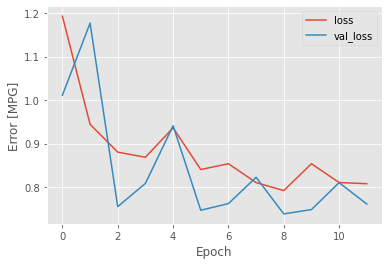

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)



In [ ]:
y_pred_nn = nn_model.predict( X_test_features )
mse=mean_squared_error( y_test, y_pred_nn )
print((mse)**(1/2))

0.86349299862219
